## Script for creating training sample
### Johan Spanners images

1) you need to flatten Johans file structure  
2) Do it on his drive in a new folder called; flatten_folder  
3) Rename each image acording to a new ID; JS + N_i  (JS = Johan Spanner)
4) Draw 5000 random images  
5) Save in new folder: sample_5000  
5) crate csv frame - that is csv with column names and row index  
6) column names = features  
7) row index = image ID  
8) codebook  
9) Page in code book showing the order of the column names so they don't have to scroll 

to mount external harddriv:
> sudo mkdir /mnt/f # f is just random letter for the mounting point  
> sudo mount -t drvfs d: /mnt/f # f is the letter choosen above, d is the drive name

Now you can access his files at location: **/mnt/f/'October Johan Archive'/Spanner**

You then have the folders Published, Raw, Submitted.  
Note to spanner: Something wrong in Pub 2006... Seems like raw or Pub

You know the file extension form the script CheckFileExytensions.ipynb


In [68]:
# mounts the drive throug terminal -sadly does not work..
#! sudo -S mount -t drvfs d: /mnt/f < /mnt/c/Users/xpn381/Documents/data/lpw.txt #måske uden txt?

#try - men så ender dit pasaword måske i en notebook... maybe even github
!echo {password}|sudo -S {command}
# password could be a var here it's said on: https://stackoverflow.com/questions/44996933/using-sudo-inside-jupyter-notebooks-cell

[sudo] password for xpn381: Sorry, try again.
[sudo] password for xpn381: 
sudo: 1 incorrect password attempt


# Code

In [69]:
import os
import cv2
from iptcinfo3 import IPTCInfo
from PIL import Image
from PIL.TiffTags import TAGS # til raw
import rawpy # Måske bedre til raw 
import imageio # for saving NEF as jpgs
import re
import zipfile
import shutil
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle

In [70]:

# origianl_IPTCInfo = IPTCInfo

# def patch_IPTCInfo(*args, **kwargs):
#     import os, sys

#     class HiddenPrints:
#         def __enter__(self):
#             self._original_stdout = sys.stdout
#             sys.stdout = open('/dev/null', 'w')

#         def __exit__(self, exc_type, exc_val, exc_tb):
#             sys.stdout = self._original_stdout

#     with HiddenPrints():
#         return origianl_IPTCInfo(*args, **kwargs)

# IPTCInfo = patch_IPTCInfo

# # iptc = IPTCInfo("/Users/tarunlalwani/Downloads/image.jpg")
# # print(iptc)

In [71]:
pkl_file = open('IPTC_keys.pkl', 'rb')

IPTC_keys = pickle.load(pkl_file)

pkl_file.close()

In [72]:
# external_dir =  "/mnt/f/OctoberJohanArchive"
external_dir =  "/mnt/f/OctoberJohanArchiveTest" # only the published images
flatten_dir =  "/mnt/f/OctoberJohanArchiveFlatten"

In [73]:
def count_files(external_dir):
    
    """Counts files in folder tree. Sanity check, and fits in the function flatten_dirs()"""
    
    count = 0
    
    for root, dirs, files in os.walk(external_dir):
        for name in files:
            count += 1
        
    return(count)

In [74]:
def mk_flatten_dir(flatten_dir):
    
    """Creates a new folder which is to be the location of the flattened folder tree. fits in the function flatten_dirs()"""
    
    if not os.path.exists(flatten_dir):
        os.mkdir(flatten_dir) # makes new dir                     
        
    # Or REPLACE old if exist
    else:
        shutil.rmtree(flatten_dir) # delets dir and content.. FOREVER!
        os.mkdir(flatten_dir) # makes new dir


In [75]:
def get_dt(meta_string):
    
    """Gets date and time from image meta data string. fits in the functions handl_..."""
                
    r = '[\d]{4}:[\d]{2}:[\d]{2} [\d]{2}:[\d]{2}:[\d]{2}'# time and, date. but is this robust? we will find out.
    
    date, time = re.search(r, meta_string).group().replace(':','').split(' ')
        
    return(date,time)

In [76]:
def handl_nef_n_cr2(old_path, new_path): # need to add new path in flatten folder eventually

    """Gets time and dats from NEF and CR2 formats. Then converts (and potientially moves) the files to .jpg. fits in function MoveConvertGetMeta"""
    
    # Rawpy works for CR2 and NEF
    raw = rawpy.imread(old_path)
    meta_stringN = str(raw.extract_thumb())

    date, time = get_dt(meta_stringN)
#     print(date, time)
    # image_check(test_imgRawNEF) 

    # Special treatment for NEF (might also work for others)
#     new_path = old_path.split('.')[0]+'TEST.jpg'  # Slick, but need to add new path in flatten folder eventually
    rgb = raw.postprocess()
    imageio.imsave(new_path, rgb)
    
    raw.close()
    
#     image_check(new_path)
    return(date, time)

In [77]:
def handl_tif(old_path, new_path):  # need to add new path in flatten folder eventually
    
    """Gets time and dats from tif format. Then converts (and potientially moves) the files to .jpg. fits in function MoveConvertGetMeta"""

    
    # PIL works for tiff
    img = Image.open(old_path)
    meta_stringT = str(img.tag.tagdata) # seems, there are slightly different timestamp. 2 hours dif it is a timezone thingy - you get the right one

    date, time = get_dt(meta_stringT)
#     print(date, time)
#     print(img.size)

#     new_path = old_path.split('.')[0]+'TEST.jpg'

    img.save(new_path) # turns it into an jpg, but does not create exif
    
    img.close()
    
#     image_check(new_path)
    return(date, time)

In [78]:
def handl_jpg(old_path, new_path): # need to add new path in flatten folder eventually

    """Gets time and dats from jpg format. Then converts(sic) (and potientially moves) the files to .jpg. fits in function MoveConvertGetMeta"""
    
    img = Image.open(old_path)
    meta_stringJ = str(img.info['exif'])

    date, time = get_dt(meta_stringJ)
#     print(date, time)
#     print(img.size)

#     new_path = old_path.split('.')[0]+'TEST.jpg'

    img.save(new_path, exif = img.info['exif']) # turns it into an jpg, and maintain exif
    img.close()

#     image_check(new_path)
    return(date, time)

In [79]:
def get_IPTC_data(old_path, new_path, date, time): # must also take new_path... date can by int right now..
    
    """Put time, date and path info in (converted and moved) image IPTC. fits into handl_... loop functions
    Rember, no IPTC gets carried over by handl_ functions automatically"""
    
    # Load stuff ----------------------------------------------------------------------------------------
    
#     new_path = old_path.split('.')[0]+'TEST.jpg' # temp!! Must come from above
    
    # info from old file
    oldinfo = IPTCInfo(old_path, force=True)
        
    # now load new new path inof
    newinfo = IPTCInfo(new_path, force=True)
    
    
    # get old IPTCs -------------------------------------------------------------------------------------
    for i in IPTC_keys:
        if not newinfo[i] and oldinfo[i]: # if newinfo is None or empty and old info is NOT empty or None
            newinfo[i] = oldinfo[i] # if you sort the string list first, you could use enumarate and strings[j]
    
    
    # get meta and path info ----------------------------------------------------------------------------

    # get info from old path structure regarding photographer and pub-status
    path_info = old_path.split("/")[4:6] # name and pub-status give the paths of JOHAN SPANNER ONLY
    
    # get meta 
    meta_keys =  ['custom1','copyright notice','date created','time created']
    strings = [str(path_info[1]), str(path_info[0]), str(date), str(time)] #(date and time) must be strings to get saved - or error. makes all strings to be safe.
    
    for j,i in enumerate(meta_keys):
        if not newinfo[i]: # if newinfo is None or empty
            newinfo[i] = strings[j] # if you sort the string list first, you could use enumarate and strings[j]
    
    # Saving and cleaning --------------------------------------------------------------------------------
    
    # save with meta and path info
    newinfo.save()# save to same file
    
    #removes wierd residual file, which appears whan I save IPTCs
    os.remove(new_path + '~')

    #print test:
#     for i in IPTC_keys:
#         if newinfo[i]:
#             print(f'key: {i}, info: {newinfo[i]}\n')

In [88]:
# FITS WITH Get_IPTC_data - in some way!
# An then into the larger loop - which will mostly supply the old_path and new_path

def MoveConvertGetMeta(old_path, new_path): # will also need new_path in time!!
    
    "Uses the handl... functions to move and convert images while also getting meta on date and time"
        
    # needs an extentsion, so must com after verification
    ext = old_path.split('.')[-1].lower() # Last entry, in case som dot is in name. lowercase just to streamline..
    
    # at point you'll new_path, so handl_ext(old_path, new_path)
    if ext == 'tif':
        date, time = handl_tif(old_path, new_path)
        print(date, time) # needs to do someting else then print: goes to IPTC
        
    elif ext == 'nef' or ext == 'cr2':
        date, time = handl_nef_n_cr2(old_path, new_path)
        print(date, time) # needs to do someting else then print: goes to IPTC
    
    elif ext == 'jpg':
        date, time = handl_jpg(old_path, new_path)
        print(date, time) # needs to do someting else then print: goes to IPTC
    
    else:
        pass #pass unknown format
    
    
    #Takes info from old IPTC (if any), meta data and path to moved and converted image IPTC
    try:
        get_IPTC_data(old_path, new_path, date, time)
    
    except:
        pass
    


# TESTING AREA

In [81]:
def image_check(img_path):

    img_array = cv2.imread(img_path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    plt.imshow(img_array)

    plt.show()

In [82]:
# submitted
test_imgSubTIF = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0128.tif"
test_imgSubJPG = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0906.jpg"
test_imgSubjpgIP = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0906.jpg"


# raw
test_imgRawNEF = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/DSC_0001.NEF"
test_imgRawCR2 = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/IMG_0001.CR2"
test_imgRawJPG = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/P3300001.JPG"

# list
old_paths = [test_imgSubTIF, test_imgRawNEF, test_imgRawCR2, test_imgRawJPG, test_imgSubjpgIP, 'falseflag.todd']

File not a JPEG, trying blindScan
Marker scan hit start of image data


/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0128.tif___/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0128TEST.jpg
20030322 121617


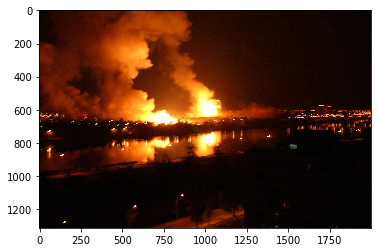

File not a JPEG, trying blindScan
Marker scan hit start of image data


/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/DSC_0001.NEF___/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/DSC_0001TEST.jpg
20030317 221429


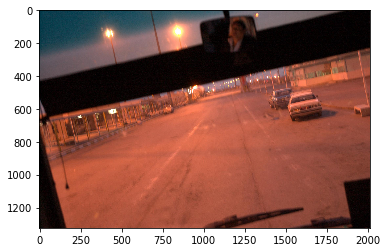

/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/IMG_0001.CR2___/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/IMG_0001TEST.jpg


File not a JPEG, trying blindScan
Marker scan hit start of image data


20090101 114317


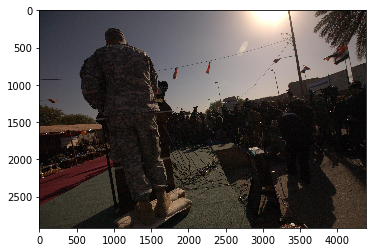

/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/P3300001.JPG___/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/P3300001TEST.jpg


Marker scan hit start of image data
Marker scan hit start of image data


20050330 072409


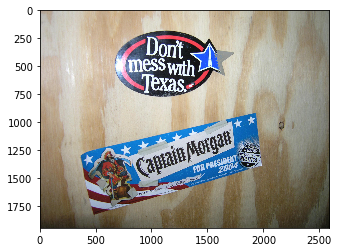

Marker scan hit start of image data


/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0906.jpg___/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0906TEST.jpg
20030416 072208


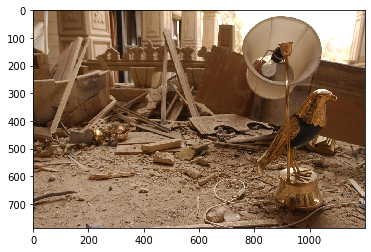

falseflag.todd___falseflagTEST.jpg


In [83]:
for old_path in old_paths:
    new_path = old_path.split('.')[0]+'TEST.jpg' #men skal så over i flatten med ny ID!!
    print(old_path +'___'+new_path )
    MoveConvertGetMeta(old_path, new_path)
    try:
        image_check(new_path)
    except:
        pass

In [84]:
# TEST!

for old_path in old_paths:
    try:
        new_path = old_path.split('.')[0]+'TEST.jpg'
        testinfo = IPTCInfo(new_path, force = True)
        print('cooool')
        
        for i in IPTC_keys:
            if testinfo[i]:
                print(f'key: {i}, info: {testinfo[i]}\n')
        
    except:
        print('less cooool')
        pass



cooool
key: date created, info: b'20030322'

key: time created, info: b'121617'

key: copyright notice, info: b'Spanner'

key: custom1, info: b'Submitted'

cooool
key: date created, info: b'20030317'

key: time created, info: b'221429'

key: copyright notice, info: b'Spanner'

key: custom1, info: b'Raw'

cooool
key: date created, info: b'20090101'

key: time created, info: b'114317'

key: copyright notice, info: b'Spanner'

key: custom1, info: b'Raw'

cooool
key: date created, info: b'20050330'

key: time created, info: b'072409'

key: copyright notice, info: b'Spanner'

key: custom1, info: b'Raw'

cooool
key: date created, info: b'20030415'

key: time created, info: b'072208'

key: city, info: b'Baghdad'

key: country/primary location name, info: b'Iraq'

key: headline, info: b"Saddam's s\xbfn Uday's palads blev ogs\x8c plyndret, men det flyder med dyrt designert\xbfj og interi\xbfr."

key: credit, info: b'Johan Rydeng Spanner'

key: copyright notice, info: b'Spanner'

key: caption/ab

# NEXT thing to be intergrated:

So the function MoveConvertGetMeta(old_path) needs to go in here.. And you need to feed it new_path

In [85]:
def flatten_dirs(external_dir, flatten_dir):
    
    time_start = time.time() # start time
    mk_flatten_dir(flatten_dir) # creates the new folder
    files_count = count_files(external_dir) # counts all files to be moved
    counter = 0 # counter for all iterations
    count_move = 0 # counter for files moved and image ID
    count_exceptions = 0 # count files not being move, due to them not being images.
    ID_front = "JS" # Johan Spanner
    
    print(f'\nstarts moving files from: {external_dir}\nto new shared parent dir: {flatten_dir}...\n')
    
    for root, dirs, files in os.walk(external_dir):
        
        for name in files: 
            
            counter += 1
            print(f'Handling file {counter} of {files_count}', end= '\r')
                        
            old_path = os.path.join(root, name) #all the info for the IPTC should be in in old_path name
            
            #store info for IPTC - moved to function get IPTC
#             path_info = old_path.split("/") # list of strings
            
            try: # you only wnat to move actual images
                
                # verify that is an image
                img = Image.open(old_path)  # open the image file
                img.verify()  # verify that it is a good image, without decoding it.. quite fast
                img.close()
                
                # do another moving al.
                
                # new path
                count_move += 1
                new_path = flatten_dir + "/" + ID_front + str(count_move) + ".jpg" # path and image ID - could also put the ID in the IPTC now you are at it.
                # seems you can call all relevant image types .jpeg and still open them - even .tif
                
                # not relevant, you jus save directly to a new distination
                
                # -----------------------------------------------------------------------
                # Moving day..
#                 shutil.copyfile(old_path, new_path) # x6 slower then move.. IPTC moves to
#                 shutil.move(old_path, new_path)# will delete the original path. Do IPTC also move? 
#                 shutil.copy(old_path, new_path) # error for both copy and copy2

                # So the other stuff goes here:
    
                MoveConvertGetMeta(old_path, new_path)

                # ------------------------------------------------------------------------
                    


            except Exception as e: # Non images you just pass
        
                count_exceptions += 1
                pass
                
    # Logging time it takes to complete operation..
    time_end = time.time()
    time_run = round((time_end - time_start)/60,2)
                    
    print(f'\n\nDone moving files to parent dir: {flatten_dir}...')

    print(f'File(s) moved: {counter-count_exceptions} out of {files_count} files')
    print(f'File(s) not moved (not images): {count_exceptions} out of {files_count} files')
    
    print(f'\nALL DONE!\nThe operation took {time_run} minutes')
    


In [86]:
# try to get rid of all the "warnings"
import warnings
warnings.filterwarnings(action='once')
# warnings.filterwarnings('ignore')

# from IPython.display import HTML
# HTML('''<script>
# code_show_err=false; 
# function code_toggle_err() {
#  if (code_show_err){
#  $('div.output_stderr').hide();
#  } else {
#  $('div.output_stderr').show();
#  }
#  code_show_err = !code_show_err
# } 
# $( document ).ready(code_toggle_err);
# </script>
# To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


starts moving files from: /mnt/f/OctoberJohanArchiveTest
to new shared parent dir: /mnt/f/OctoberJohanArchiveFlatten...



/home/xpn381/anaconda3/lib/python3.7/site-packages/iptcinfo3.py:719: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("File not a JPEG, trying blindScan")
File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 221429


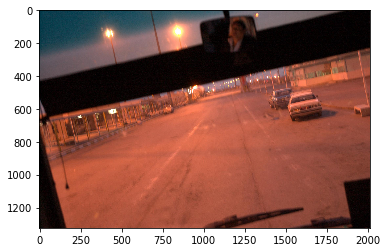

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 221632


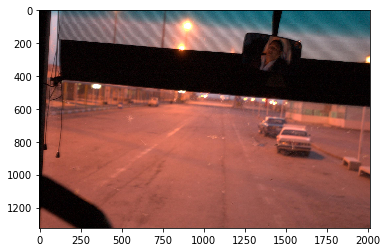

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 221914


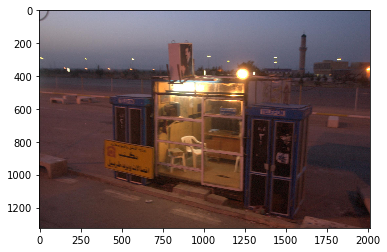

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222252


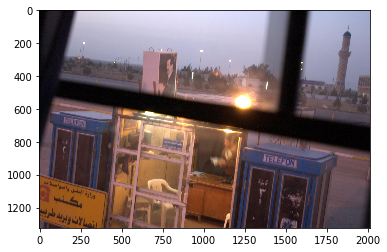

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222432


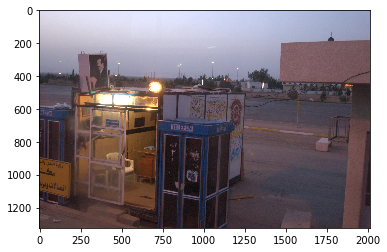

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222442


File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222452


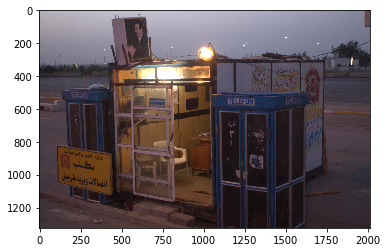

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222555


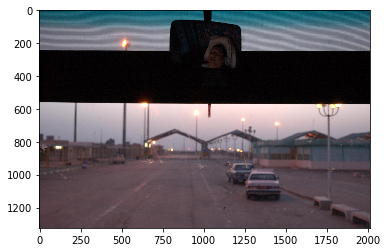

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222610


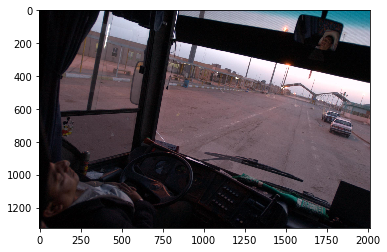

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222611


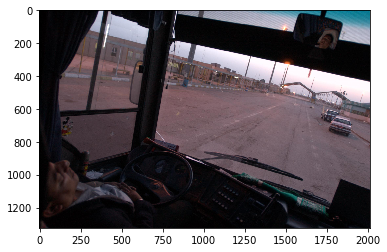

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222634


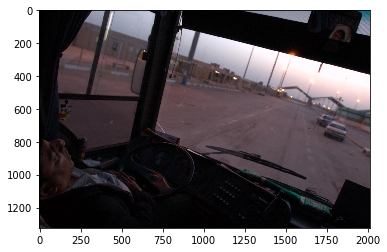

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222654


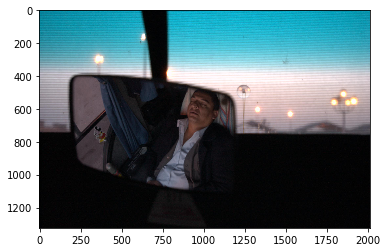

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222719


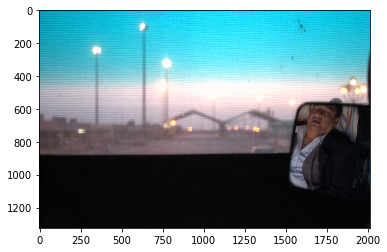

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222724


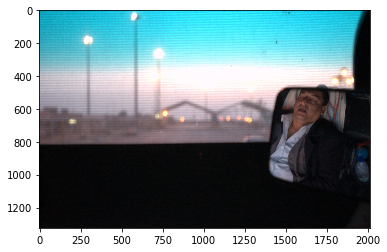

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222743


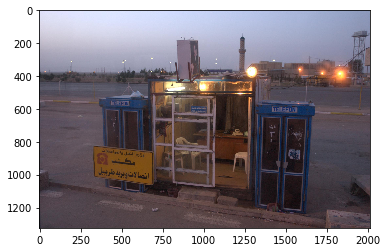

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222823


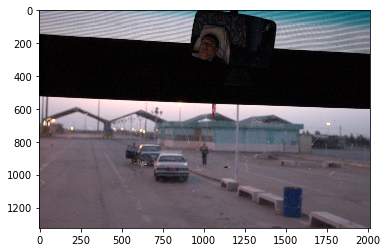

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 222827


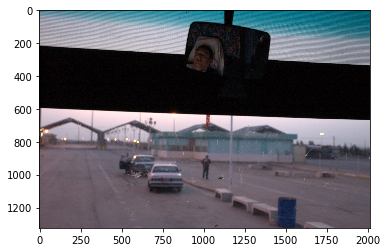

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223014


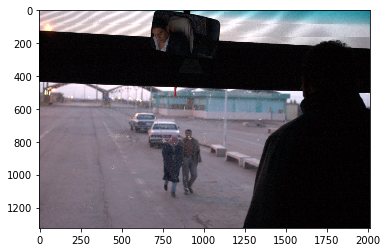

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223130


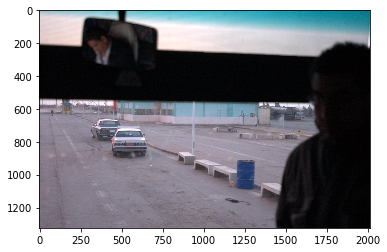

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223134


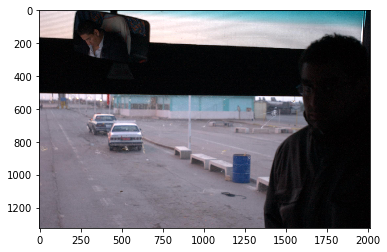

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223219


File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223222


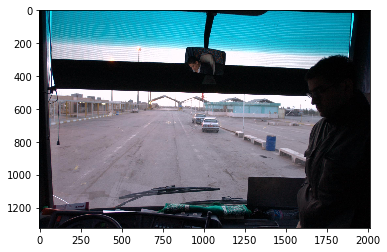

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223251


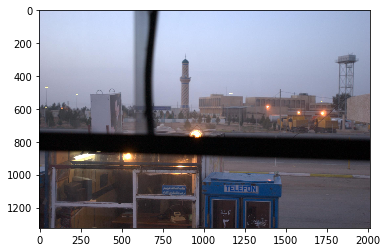

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223255


File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223324


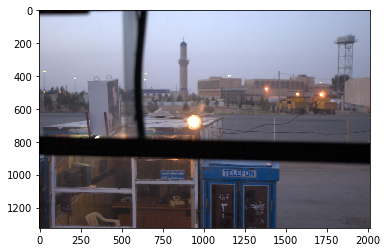

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223326


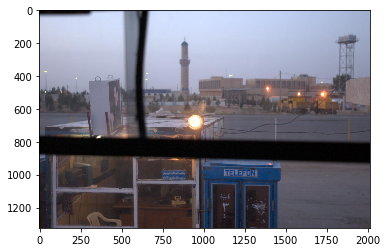

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223353


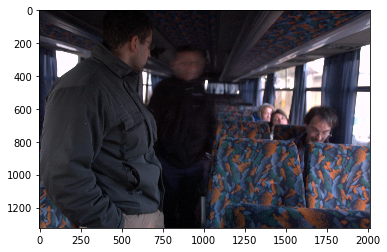

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223354


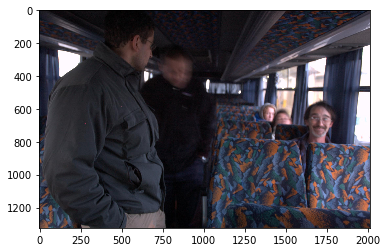

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223440


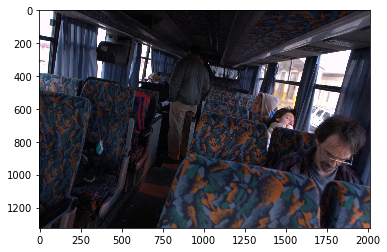

File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223549


File not a JPEG, trying blindScan
Marker scan hit start of image data


20030317 223554


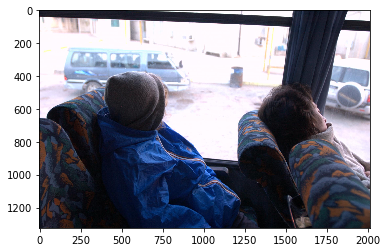

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/xpn381/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-87-52d71de02119>", line 1, in <module>
    flatten_dirs(external_dir, flatten_dir)
  File "<ipython-input-85-c7cb354024ba>", line 49, in flatten_dirs
    MoveConvertGetMeta(old_path, new_path)
  File "<ipython-input-80-61cc6c97070b>", line 17, in MoveConvertGetMeta
    date, time = handl_nef_n_cr2(old_path, new_path)
  File "<ipython-input-76-c337ad3a0020>", line 15, in handl_nef_n_cr2
    rgb = raw.postprocess()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xpn381/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_tra

KeyboardInterrupt: 

In [87]:
flatten_dirs(external_dir, flatten_dir)

----
# OLD Construction:

In [137]:
test_imgSubjpgIP.split('/')[4:6]

['Spanner', 'Submitted']

In [117]:
test_imgSubjpgIP = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0906.jpg"
test_imgSubjpgIP2 = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0906TEST.jpg"
test_imgSubjpgIP3 = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0906TESTCopy.jpg"

So the get IPTC should both bring over existing IPTC and put in the new info... but is the really to functions?

In [186]:
def get_IPTC_data(old_path, date, time): # must also take new_path... date can by int right now..
    
    """Put time, date and path info in (converted and moved) image IPTC. fits into handl_... loop functions
    Rember, no IPTC gets carried over by handl_ functions automatically"""
    
    new_path = old_path.split('.')[0]+'TEST.jpg' # temp!! Must come from above
    
    oldinfo = IPTCInfo(old_path, force=True)
    
#     newinfo = IPTCInfo(new_path, force=True)
    
    oldinfo.save_as(new_path) # copying the old info
#     os.remove(new_path + '~')#removes wierd residual file

    # now load new new path inof
    newinfo = IPTCInfo(new_path, force=True)
    
    # get info from old path structure regarding photographer and pub-status
    path_info = old_path.split("/")[4:6] # name and pub-status give the paths of JOHAN SPANNER ONLY
    
    # get meta 
    meta_keys =  ['custom1','copyright notice','date created','time created']
    strings = [str(path_info[1]), str(path_info[0]), str(date), str(time)] #(date and time) must be strings to get saved - or error. makes all strings to be safe.
    
    for j,i in enumerate(meta_keys):
        if not newinfo[i]: # if newinfo is None or empty
            newinfo[i] = strings[j] # if you sort the string list first, you could use enumarate and strings[j]
    
    # save with meta and path info
    newinfo.save()# save to same file
    
    #removes wierd residual file, which appears whan I save IPTCs
    os.remove(new_path + '~')

    #print test:
#     for i in IPTC_keys:
#         if newinfo[i]:
#             print(f'key: {i}, info: {newinfo[i]}\n')

In [187]:
get_IPTC_data(test_imgSubjpgIP, 1, 'ds')

In [192]:
testinfo = IPTCInfo(test_imgSubjpgIP, force = True) 

for i in IPTC_keys:
    if testinfo[i]:
        print(f'key: {i}, info: {testinfo[i]}\n')

key: date created, info: b'20030415'

key: city, info: b'Baghdad'

key: country/primary location name, info: b'Iraq'

key: headline, info: b"Saddam's s\xbfn Uday's palads blev ogs\x8c plyndret, men det flyder med dyrt designert\xbfj og interi\xbfr."

key: credit, info: b'Johan Rydeng Spanner'

key: caption/abstract, info: b'                               '



In [165]:
testinfo.save_as?

Signature: testinfo.save_as(newfile, options=None)
Docstring: Saves Jpeg with IPTC data to a given file name.
File:      ~/anaconda3/lib/python3.7/site-packages/iptcinfo3.py
Type:      method


In [58]:
get_IPTC_data(test_imgSubjpgIP)#, 1, 2)

Data "b"Saddam's s\xbfn Uday's palads blev ogs\x8c plyndret, men det flyder med dyrt designert\xbfj og interi\xbfr."" is not in encoding utf8!


key: date created, info: 20030415

key: time created, info: some time

key: city, info: Baghdad

key: country/primary location name, info: Iraq

key: headline, info: Saddam's s�n Uday's palads blev ogs� plyndret, men det flyder med dyrt designert�j og interi�r.

key: credit, info: Johan Rydeng Spanner

key: copyright notice, info: Spanner

key: caption/abstract, info:                                

key: custom1, info: submitted



In [ ]:
def MoveConvertGetMeta(old_path): # will also need new_path in time!!
    
    "Uses the handl... functions to move and convert images while also getting meta on date and time"
        
    # needs an extentsion, so must com after verification
    ext = old_path.split('.')[-1].lower() # Last entry, in case som dot is in name. lowercase just to streamline..
    
    # at point you'll new_path, so handl_ext(old_path, new_path)
    if ext == 'tif':
        date, time = handl_tif(old_path)
        print(date, time) # needs to do someting else then print: goes to IPTC
        
    elif ext == 'nef' or ext == 'cr2':
        date, time = handl_nef_n_cr2(old_path)
        print(date, time) # needs to do someting else then print: goes to IPTC
    
    elif ext == 'jpg':
        date, time = handl_jpg(old_path)
        print(date, time) # needs to do someting else then print: goes to IPTC
    
    else:
        pass #pass unknown format
    
    
    #IPTC function here! takes old path to get old IPTC info, takes date and time local vars - gives it all to new path
    get_IPTC_data(old_path, date, time)# will also take new_path in time

In [ ]:
# test_imgSubTIF = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0128.tif"




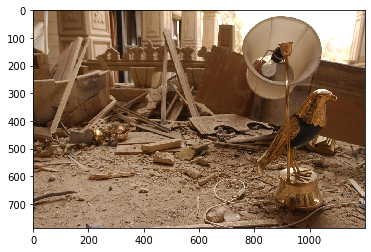

('20030416', '072208')

In [30]:
handl_jpg(test_imgSubjpgIP)

In [32]:
get_IPTC_data(test_imgSubjpgIP2)

Marker scan hit start of image data


key: date created, info: 20030416

key: time created, info: 072208

key: copyright notice, info: Spanner

key: custom1, info: submitted



# OLD - much works, and should be used.

In [ ]:
def get_IPTC_data(image_path):
    info = IPTCInfo(image_path, force=True, inp_charset='utf8')
    
    keys = ['custom1','copyright notice','date created','time created'] #or by-line for name?
    strings = ['submitted','Spanner',' a date', 'some time'] # submitted and copyright notice you get from path, date and time created you get from..., 
    
    for j,i in enumerate(keys):
        if info[i] == None or len(info[i]) < 1:
                info[i] = strings[j] # if you sort the string list first, you could use enumarate and strings[j]
                
    #--------------------------------------------
    
    for i in dict_keys:
        if info[i] != None:
            if len(info[i]) > 0: 
                print(f'key: {i}, info: {info[i]}\n')

In [5]:
# def infoIPTC() 
#     """Takes infomation from the image path string, and add it to the IPTC. Ex, wheter the is is raw, edit or puplished"""

In [6]:
# #OLD but working!!!!!
# def flatten_dirs(external_dir, flatten_dir):
    
#     time_start = time.time() # start time
#     mk_flatten_dir(flatten_dir) # creates the new folder
#     files_count = count_files(external_dir) # counts all files to be moved
#     counter = 0 # counter for all iterations
#     count_move = 0 # counter for files moved and image ID
#     count_exceptions = 0 # count files not being move, due to them not being images.
#     ID_front = "JS" # Johan Spanner
    
#     print(f'\nstarts moving files from: {external_dir}\nto new shared parent dir: {flatten_dir}...\n')
    
#     for root, dirs, files in os.walk(external_dir):
        
#         for name in files: 
            
#             counter += 1
#             print(f'Handling file {counter} of {files_count}', end= '\r')
                        
#             old_path = os.path.join(root, name) #all the info for the IPTC should be in in old_path name
            
#             #store info for IPTC
#             path_info = old_path.split("/") # list of strings
            
#             try: # you only wnat to move actual images
                
#                 # verify that is an image
#                 img = Image.open(old_path)  # open the image file
#                 img.verify()  # verify that it is a good image, without decoding it.. quite fast
#                 img.close()
                                
#                 # new path
#                 count_move += 1
#                 new_path = flatten_dir + "/" + ID_front + str(count_move) + ".jpeg" # path and image ID - could also put the ID in the IPTC now you are at it.
#                 # seems you can call all relevant image types .jpeg and still open them - even .tif
                                
#                 # Moving day..
#                 shutil.copyfile(old_path, new_path) # x6 slower then move.. IPTC moves to
# #                 shutil.move(old_path, new_path)# will delete the original path. Do IPTC also move? 
# #                 shutil.copy(old_path, new_path) # error for both copy and copy2

#             except Exception as e: # Non images you just pass
        
#                 count_exceptions += 1
#                 pass
                
#     # Logging time it takes to complete operation..
#     time_end = time.time()
#     time_run = round((time_end - time_start)/60,2)
                    
#     print(f'\n\nDone moving files to parent dir: {flatten_dir}...')

#     print(f'File(s) moved: {counter-count_exceptions} out of {files_count} files')
#     print(f'File(s) not moved (not images): {count_exceptions} out of {files_count} files')
    
#     print(f'\nALL DONE!\nThe operation took {time_run} minutes')
    


In [7]:
def flatten_dirs(external_dir, flatten_dir):
    
    time_start = time.time() # start time
    mk_flatten_dir(flatten_dir) # creates the new folder
    files_count = count_files(external_dir) # counts all files to be moved
    counter = 0 # counter for all iterations
    count_move = 0 # counter for files moved and image ID
    count_exceptions = 0 # count files not being move, due to them not being images.
    ID_front = "JS" # Johan Spanner
    
    print(f'\nstarts moving files from: {external_dir}\nto new shared parent dir: {flatten_dir}...\n')
    
    for root, dirs, files in os.walk(external_dir):
        
        for name in files: 
            
            counter += 1
            print(f'Handling file {counter} of {files_count}', end= '\r')
                        
            old_path = os.path.join(root, name) #all the info for the IPTC should be in in old_path name
            
            #store info for IPTC - moved to function get IPTC
#             path_info = old_path.split("/") # list of strings
            
            try: # you only wnat to move actual images
                
                # verify that is an image
                img = Image.open(old_path)  # open the image file
                img.verify()  # verify that it is a good image, without decoding it.. quite fast
                img.close()
                
                # do another moving al.
                
                # new path
                count_move += 1
                new_path = flatten_dir + "/" + ID_front + str(count_move) + ".jpeg" # path and image ID - could also put the ID in the IPTC now you are at it.
                # seems you can call all relevant image types .jpeg and still open them - even .tif
                
                # not relevant, you jus save directly to a new distination
                
                # Moving day..
                shutil.copyfile(old_path, new_path) # x6 slower then move.. IPTC moves to
#                 shutil.move(old_path, new_path)# will delete the original path. Do IPTC also move? 
#                 shutil.copy(old_path, new_path) # error for both copy and copy2

            except Exception as e: # Non images you just pass
        
                count_exceptions += 1
                pass
                
    # Logging time it takes to complete operation..
    time_end = time.time()
    time_run = round((time_end - time_start)/60,2)
                    
    print(f'\n\nDone moving files to parent dir: {flatten_dir}...')

    print(f'File(s) moved: {counter-count_exceptions} out of {files_count} files')
    print(f'File(s) not moved (not images): {count_exceptions} out of {files_count} files')
    
    print(f'\nALL DONE!\nThe operation took {time_run} minutes')
    


In [8]:
flatten_dirs(external_dir, flatten_dir)


starts moving files from: /mnt/f/OctoberJohanArchiveTest
to new shared parent dir: /mnt/f/OctoberJohanArchiveFlatten...

Handling file 191 of 191

Done moving files to parent dir: /mnt/f/OctoberJohanArchiveFlatten...
File(s) moved: 188 out of 191 files
File(s) not moved (not images): 3 out of 191 files

ALL DONE!
The operation took 0.43 minutes


In [9]:
test_img = "/mnt/f/OctoberJohanArchive/Spanner/Submitted/2003/031703Jylleditfirstnight/A-edit/DSC_0148.tif"

test_img.split("/")#[5]

['',
 'mnt',
 'f',
 'OctoberJohanArchive',
 'Spanner',
 'Submitted',
 '2003',
 '031703Jylleditfirstnight',
 'A-edit',
 'DSC_0148.tif']

In [10]:
external_dir

'/mnt/f/OctoberJohanArchiveTest'

## Check IPTC in moved images.

'date created' = date   
'time created' = time  
'copyright notice' = Johan spanner  
'custom1' = raw, submitted, pulished  

In [11]:
dict_keys = ['object name', 
             'edit status', 
             'editorial update', 
             'urgency', 
             'subject reference', 
             'category', 
             'supplemental category', 
             'fixture identifier', 
             'keywords', 
             'content location code', 
             'content location name', 
             'release date', 
             'release time', 
             'expiration date', 
             'expiration time', 
             'special instructions', 
             'action advised', 
             'reference service', 
             'reference date', 
             'reference number', 
             'date created', 
             'time created', 
             'digital creation date', 
             'digital creation time', 
             'originating program', 
             'program version', 
             'object cycle', 
             'by-line', 
             'by-line title', 
             'city', 
             'sub-location', 
             'province/state', 
             'country/primary location code', 
             'country/primary location name', 
             'original transmission reference', 
             'headline', 
             'credit', 
             'source', 
             'copyright notice', 
             'contact', 
             'caption/abstract', 
             'local caption', 
             'writer/editor', 
             'image type', 
             'image orientation', 
             'language identifier', 
             'custom1', 
             'custom2', 
             'custom3', 
             'custom4', 
             'custom5', 
             'custom6', 
             'custom7', 
             'custom8', 
             'custom9', 
             'custom10', 
             'custom11', 
             'custom12', 
             'custom13', 
             'custom14', 
             'custom15', 
             'custom16', 
             'custom17', 
             'custom18', 
             'custom19', 
             'custom20'] # surely you can get this list from somewhere...
# save as a pickle so you don't have to look at this shit.

In [12]:
def get_IPTC_data(image_path):
    info = IPTCInfo(image_path, force=True, inp_charset='utf8')
    
    keys = ['custom1','copyright notice','date created','time created'] #or by-line for name?
    strings = ['submitted','Spanner',' a date', 'some time'] # submitted and copyright notice you get from path, date and time created you get from..., 
    
    for j,i in enumerate(keys):
        if info[i] == None or len(info[i]) < 1:
                info[i] = strings[j] # if you sort the string list first, you could use enumarate and strings[j]
                
    #--------------------------------------------
    
    for i in dict_keys:
        if info[i] != None:
            if len(info[i]) > 0: 
                print(f'key: {i}, info: {info[i]}\n')


# construction:

In [13]:
# submitted
test_imgSubTIF = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0128.tif"
test_imgSubJPG = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Submitted/DSC_0906.jpg"

# raw
test_imgRawNEF = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/DSC_0001.NEF"
test_imgRawCR2 = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/IMG_0001.CR2"
test_imgRawJPG = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/P3300001.JPG"

# test_imgRawNEF = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/DSC_0040.NEF"



In [14]:
def get_IPTC_data(image_path):
    
    info = IPTCInfo(image_path, force=True) #, inp_charset='utf8')
    image = Image.open(image_path)
    
    # should be somewhere else..
#     image = image.convert('RGB')
#     image.save(image_path) 
    #---------------------------
#     info = IPTCInfo(image_path, force=True, inp_charset='utf8')

    
    try:
        txt = str(image.info['exif']) # exif are mostly JPEG - what if I convert myself?
    
        r = '[\d]{4}:[\d]{2}:[\d]{2} [\d]{2}:[\d]{2}:[\d]{2}'# time and, date. but is this robust? we will find out.
    
        date, time = re.search(r, txt).group().replace(':','').split(' ')
        
    
    except:
        date = 'D'
        time = 'T'
        pass
    
    keys = ['custom1','copyright notice','date created','time created'] #or by-line for name?
    strings = ['submitted','Spanner', date, time] # submitted and copyright notice you get from path, date and time created you get from..., 
    
    for j,i in enumerate(keys):
        if info[i] == None or len(info[i]) < 1:
                info[i] = strings[j]
                
#Print for test--------------------------------------------
    
    for i in dict_keys:
        if info[i] != None:
            if len(info[i]) > 0: 
                print(f'key: {i}, info: {info[i]}\n')


In [15]:
def get_dt(meta_string):
    """Gets date and time from image meta data string"""
                
    r = '[\d]{4}:[\d]{2}:[\d]{2} [\d]{2}:[\d]{2}:[\d]{2}'# time and, date. but is this robust? we will find out.
    
    date, time = re.search(r, meta_string).group().replace(':','').split(' ')
        
    return(date,time)

In [16]:
def image_check(img_path):

    img_array = cv2.imread(img_path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    plt.imshow(img_array)

    plt.show()


# Construction:

# Merging stuff:

In [17]:
## Working functions:

In [18]:
def handl_nef_n_cr2(old_path): # need to add new path in flatten folder eventually

    # Rawpy works for CR2 and NEF
    raw = rawpy.imread(old_path)
    meta_stringN = str(raw.extract_thumb())

    date, time = get_dt(meta_stringN)
#     print(date, time)
    # image_check(test_imgRawNEF) 

    # Special treatment for NEF (might also work for others)
    new_local = old_path.split('.')[0]+'TEST.jpg'  # Slick, but need to add new path in flatten folder eventually
    rgb = raw.postprocess()
    imageio.imsave(new_local, rgb)
    
    raw.close()
    
    image_check(new_local)
    return(date, time)

In [19]:
def handl_tif(old_path):  # need to add new path in flatten folder eventually
    # PIL works for tiff
    img = Image.open(old_path)
    meta_stringT = str(img.tag.tagdata) # seems, there are slightly different timestamp. 2 hours dif it is a timezone thingy - you get the right one

    date, time = get_dt(meta_stringT)
#     print(date, time)
#     print(img.size)

    new_local = old_path.split('.')[0]+'TEST.jpg'

    img.save(new_local) # turns it into an jpg, but does not create exif
    
    img.close()
    
    image_check(new_local)
    return(date, time)

In [20]:
# def handel_jpg(old_path): # need to add new path in flatten folder eventually
#     # PIL works for jpeg 
#     img = Image.open(old_path)
#     meta_stringJ = str(img.info['exif'])# Exif only for jpeg

#     date, time = get_dt(meta_stringJ)
#     print(date, time)
# #     print(img.size)

#     new_local = old_path.split('.')[0]+'TEST.jpg'

#     img.save(new_local, exif = img.info['exif']) # turns it into an jpg, and maintain exif
    
#     img.close()
    
#     image_check(new_local)
#     return(date, time)

In [21]:
def handl_jpg(old_path): # need to add new path in flatten folder eventually

    img = Image.open(old_path)
    meta_stringJ = str(img.info['exif'])

    date, time = get_dt(meta_stringJ)
#     print(date, time)
#     print(img.size)

    new_local = old_path.split('.')[0]+'TEST.jpg'

    img.save(new_local, exif = img.info['exif']) # turns it into an jpg, and maintain exif
    img.close()

    image_check(new_local)
    return(date, time)

In [22]:
# date, time = handl_nef_n_cr2(test_imgRawNEF)
# print(date, time)
# print('\n---------------------------\n')

# date, time = handl_nef_n_cr2(test_imgRawCR2)
# print(date, time)
# print('\n---------------------------\n')

# date, time = handl_tif(test_imgSubTIF)
# print(date, time)
# print('\n---------------------------\n')

# date, time = handl_jpg(test_imgRawJPG)
# print(date, time)
# print('\n---------------------------\n')


## Loops

In [23]:
paths = [test_imgSubTIF, test_imgRawNEF, test_imgRawCR2, 'falseflag.todd', test_imgRawJPG]

In [24]:
# FITS WITH Get_IPTC_data - in some way!
# An then into the larger loop - which will mostly supply the old_path and new_path

def MoveConvertGetMeta(old_path): # will also need new_path in time!!
        
    # needs an extentsion, so must com after verification
    ext = old_path.split('.')[-1].lower() # Last entry, in case som dot is in name. lowercase just to streamline..
    
    # at point you'll new_path, so handl_ext(old_path, new_path)
    if ext == 'tif':
        date, time = handl_tif(old_path)
        print(date, time) # needs to do someting else then print: goes to IPTC
        
    elif ext == 'nef' or ext == 'cr2':
        date, time = handl_nef_n_cr2(old_path)
        print(date, time) # needs to do someting else then print: goes to IPTC
    
    elif ext == 'jpg':
        date, time = handl_jpg(old_path)
        print(date, time) # needs to do someting else then print: goes to IPTC
    
    else:
        pass #pass unknown format
    
    
    #IPTC thing here!

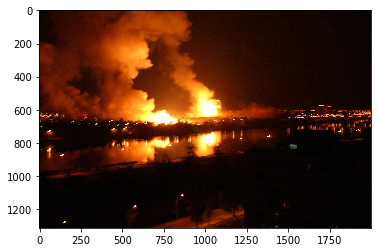

20030322 121617


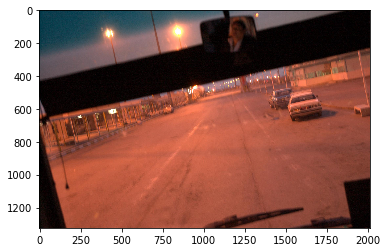

20030317 221429


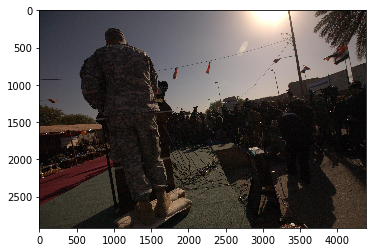

20090101 114317


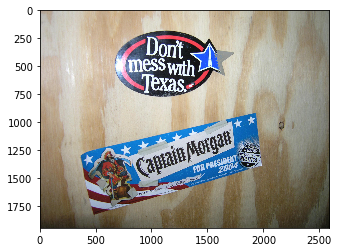

20050330 072409


In [25]:
for path in paths:
    MoveConvertGetMeta(path)

# OLD:

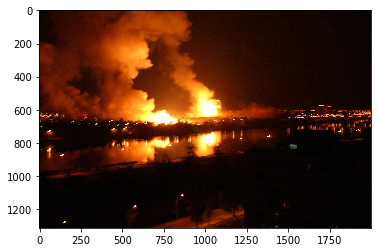

20030322 121617


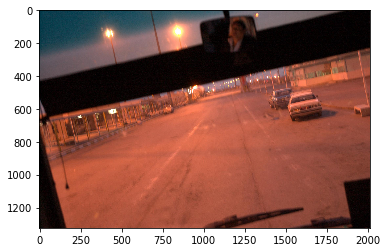

20030317 221429


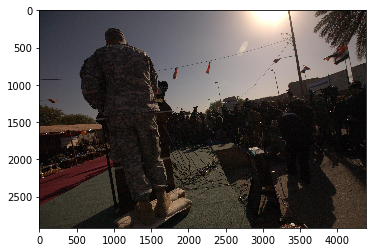

20090101 114317


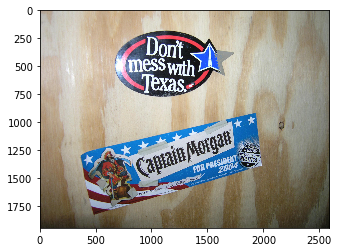

20050330 072409


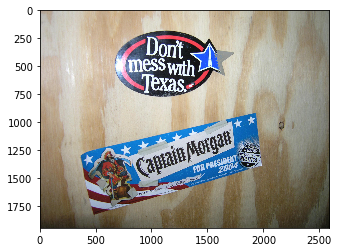

20050330 072409


In [221]:
# loop:
for path in paths:
    
    # needs an extentsion, so must com after verification
    ext = path.split('.')[-1].lower() # Last entry, in case som dot is in name. lowercase just to streamline..
    
    # at point you'll new_path, so handl_ext(old_path, new_path)
    if ext == 'tif':
        date, time = handl_tif(path)
        print(date, time)
        
    elif ext == 'nef' or ext == 'cr2':
        date, time = handl_nef_n_cr2(path)
        print(date, time)
    
    elif ext == 'jpg':
        date, time = handl_jpg(path)
        print(date, time)
    
    else:
        pass #pass unknown format
    

In [113]:
test_imgSubTIF.split('.')[-1]

'tif'

test_imgSubTIF  
test_imgRawNEF  
test_imgRawCR2  
test_imgRawJPG 

20030317 221429


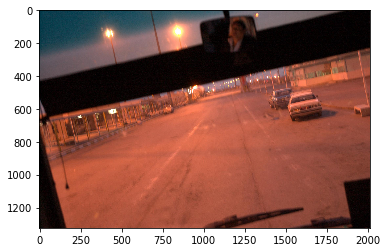

In [167]:
handel_nef_n_cr2(test_imgRawNEF)

20090101 114317


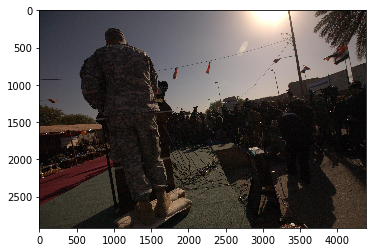

In [168]:
handel_nef_n_cr2(test_imgRawCR2)

20030322 121617
(2000, 1312)


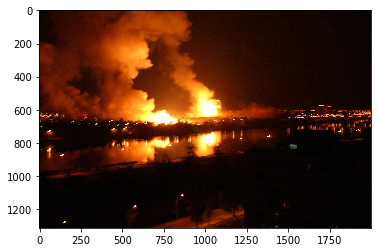

In [169]:
handel_tif(test_imgSubTIF)

20050330 072409
(2592, 1944)


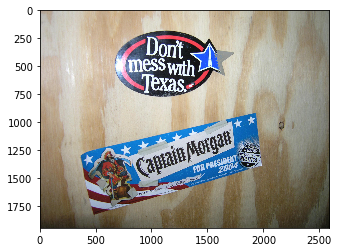

In [176]:
handel_jpg(test_imgRawJPG)

# Working singles!

20090101 114317


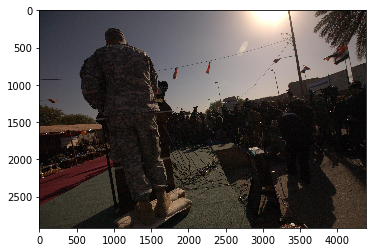

In [142]:
# WORKS for CR2 and NEF
raw = rawpy.imread(test_imgRawCR2)
meta_stringN = str(raw.extract_thumb())

date, time = get_dt(meta_stringN)
print(date, time)
# image_check(test_imgRawNEF) 

# Special treatment for NEF (might also work for others)
new_local = test_imgRawCR2.split('.')[0]+'TEST.jpg'
rgb = raw.postprocess()
imageio.imsave(new_local, rgb)

raw.close()

image_check(new_local)

20030317 221429


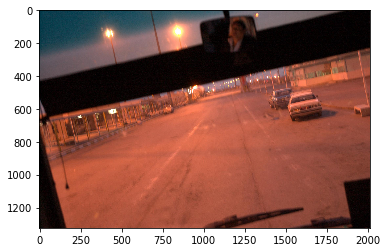

In [143]:
# SAME! works for CR2 and NEF
raw = rawpy.imread(test_imgRawNEF)
meta_stringN = str(raw.extract_thumb())

date, time = get_dt(meta_stringN)
print(date, time)
# image_check(test_imgRawNEF) 

# Special treatment for NEF (might also work for others)
new_local = test_imgRawNEF.split('.')[0]+'TEST.jpg'
rgb = raw.postprocess()
imageio.imsave(new_local, rgb)

raw.close()

image_check(new_local)

# WORKS

20030322 121617
(2000, 1312)


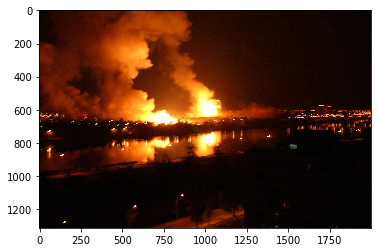

In [144]:
# PIL works for tiff
img = Image.open(test_imgSubTIF)
meta_stringT = str(img.tag.tagdata) # seems, there are slightly different timestamp [2 hours dif - time zone tingy?], but one is correctly formatted.

date, time = get_dt(meta_stringT)
print(date, time)
print(img.size)
# image_check(test_imgSubTIF)

# Does actually not need converting before plotting
# im = Image.open(test_imgSubTIF) # already open in PIL

new_local = test_imgSubTIF.split('.')[0]+'TEST.jpg'

img.save(new_local) # turns it into an jpg, but does not create exif

img.close()

image_check(new_local)

In [19]:
# meta_stringT # wrong time, mbut it seems like a human mistake

In [154]:
#D:\OctoberJohanArchiveTestOld\Spanner\Raw
    
test_imgRawJPG = "/mnt/f/OctoberJohanArchiveTestOld/Spanner/Raw/P3300001.JPG"


20050330 072409
(2592, 1944)


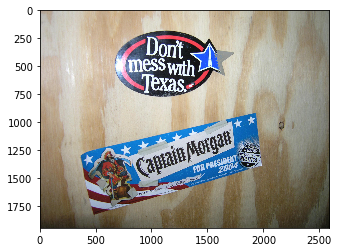

In [161]:
# PIL works for jpeg
img = Image.open(test_imgRawJPG)
meta_stringJ = str(img.info['exif'])

date, time = get_dt(meta_stringJ)
print(date, time)
print(img.size)

# image_check(test_imgRawJPG) # already jpg

# Does actually not need converting before plotting
# im = Image.open(test_imgSubTIF)

new_local = test_imgRawJPG.split('.')[0]+'TEST.jpg'

img.save(new_local, exif = img.info['exif']) # turns it into an jpg, and maintain exif
img.close()

image_check(new_local)

In [163]:
img = Image.open(new_local)
len(img.info['exif'])>0

True

# CONSTRUCTION:

In [89]:
try:
    img = Image.open(test_imgSubTIF)
    img.info['exif']
    
except:
    img = Image.open(test_imgRawJPG)
    img.info['exif']

b'Exif\x00\x00II*\x00\x08\x00\x00\x00\x0c\x00\x0e\x01\x02\x00 \x00\x00\x00\x9e\x00\x00\x00\x0f\x01\x02\x00\x14\x00\x00\x00\xbe\x00\x00\x00\x10\x01\x02\x00\x08\x00\x00\x00\xd6\x00\x00\x00\x12\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00\xee\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00\xf6\x00\x00\x00(\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x001\x01\x02\x00\x08\x00\x00\x00\xfe\x00\x00\x002\x01\x02\x00\x14\x00\x00\x00\x1e\x01\x00\x00\x13\x02\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00i\x87\x04\x00\x01\x00\x00\x00&\x02\x00\x00\xa5\xc4\x07\x00\x04\x01\x00\x002\x01\x00\x00\x96\x04\x00\x00OLYMPUS DIGITAL CAMERA         \x00OLYMPUS CORPORATION\x00\x00\x00\x00\x00C5060WZ\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00v756-82\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x002005:03:30 07:24:09\x00PrintIM\x000250\x00\x00\x14\x00\x01\x00\x12\x00

# REST:

In [ ]:
# works for tiff
with Image.open(test_imgSubTIF) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}

In [167]:
img = Image.open(test_imgSubTIF)
str(img.tag.tagdata)

In [178]:
for key in img.tag.keys():
    print(key) # men det er næppe det samme universielt...

256
257
258
259
262
34377
273
277
278
279
282
283
284
296
34665
305
306
34675
700
254


In [159]:
img.tag[34377]

(b'8BIM\x04%\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008BIM\x03\xea\x00\x00\x00\x00\x1d\xad<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE plist PUBLIC "-//Apple Computer//DTD PLIST 1.0//EN" "http://www.apple.com/DTDs/PropertyList-1.0.dtd">\n<plist version="1.0">\n<dict>\n\t<key>com.apple.print.PageFormat.PMHorizontalRes</key>\n\t<dict>\n\t\t<key>com.apple.print.ticket.creator</key>\n\t\t<string>com.apple.printingmanager</string>\n\t\t<key>com.apple.print.ticket.itemArray</key>\n\t\t<array>\n\t\t\t<dict>\n\t\t\t\t<key>com.apple.print.PageFormat.PMHorizontalRes</key>\n\t\t\t\t<real>72</real>\n\t\t\t\t<key>com.apple.print.ticket.client</key>\n\t\t\t\t<string>com.apple.printingmanager</string>\n\t\t\t\t<key>com.apple.print.ticket.modDate</key>\n\t\t\t\t<date>2003-03-22T10:07:41Z</date>\n\t\t\t\t<key>com.apple.print.ticket.stateFlag</key>\n\t\t\t\t<integer>0</integer>\n\t\t\t</dict>\n\t\t</array>\n\t</dict>\n\t<key>com.apple.print.PageFormat.P

In [185]:
str(img.tag.tagdata)

'{254: b\'\\x00\\x00\\x00\\x00\', 256: b\'\\xd0\\x07\', 257: b\' \\x05\', 258: b\'\\x10\\x00\\x10\\x00\\x10\\x00\', 259: b\'\\x01\\x00\', 262: b\'\\x02\\x00\', 273: b\'\\xb0F\\x00\\x00\', 277: b\'\\x03\\x00\', 278: b\' \\x05\', 279: b\'\\x00<\\xf0\\x00\', 282: b"\\xc0\\xc6-\\x00\\x10\'\\x00\\x00", 283: b"\\xc0\\xc6-\\x00\\x10\'\\x00\\x00", 284: b\'\\x01\\x00\', 296: b\'\\x02\\x00\', 305: b\'Adobe Photoshop 7.0\\x00\', 306: b\'2003:03:22 12:16:17\\x00\', 700: b\'<?xpacket begin=\\\'\\xef\\xbb\\xbf\\\' id=\\\'W5M0MpCehiHzreSzNTczkc9d\\\'?>\\n<?adobe-xap-filters esc="CR"?>\\n<x:xapmeta xmlns:x=\\\'adobe:ns:meta/\\\' x:xaptk=\\\'XMP toolkit 2.8.2-33, framework 1.5\\\'>\\n<rdf:RDF xmlns:rdf=\\\'http://www.w3.org/1999/02/22-rdf-syntax-ns#\\\' xmlns:iX=\\\'http://ns.adobe.com/iX/1.0/\\\'>\\n\\n <rdf:Description about=\\\'uuid:3c9ad561-5df2-11d7-818b-96dac26cff60\\\'\\n  xmlns:xapMM=\\\'http://ns.adobe.com/xap/1.0/mm/\\\'>\\n  <xapMM:DocumentID>adobe:docid:photoshop:212b550f-5df1-11d7-818b-96d

In [ ]:
with Image.open(test_imgSubTIF) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}

In [139]:
with Image.open(test_imgSubTIF) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}

In [140]:
meta_dict

{'ImageWidth': (2000,),
 'ImageLength': (1312,),
 'BitsPerSample': (16, 16, 16),
 'Compression': (1,),
 'PhotometricInterpretation': (2,),
 'PhotoshopInfo': (b'8BIM\x04%\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008BIM\x03\xea\x00\x00\x00\x00\x1d\xad<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE plist PUBLIC "-//Apple Computer//DTD PLIST 1.0//EN" "http://www.apple.com/DTDs/PropertyList-1.0.dtd">\n<plist version="1.0">\n<dict>\n\t<key>com.apple.print.PageFormat.PMHorizontalRes</key>\n\t<dict>\n\t\t<key>com.apple.print.ticket.creator</key>\n\t\t<string>com.apple.printingmanager</string>\n\t\t<key>com.apple.print.ticket.itemArray</key>\n\t\t<array>\n\t\t\t<dict>\n\t\t\t\t<key>com.apple.print.PageFormat.PMHorizontalRes</key>\n\t\t\t\t<real>72</real>\n\t\t\t\t<key>com.apple.print.ticket.client</key>\n\t\t\t\t<string>com.apple.printingmanager</string>\n\t\t\t\t<key>com.apple.print.ticket.modDate</key>\n\t\t\t\t<date>2003-03-22T10:07:41Z</date>\n\

In [90]:
get_IPTC_data(test_imgRawNjpg)

Marker scan hit start of image data


key: date created, info: D

key: time created, info: T

key: copyright notice, info: Spanner

key: custom1, info: submitted



In [48]:
info = IPTCInfo(test_imgRaw2, force=True, inp_charset='utf8')

Marker scan hit start of image data


In [41]:
image.convert?

Object `image.convert` not found.


In [50]:
# Open the image and access the metadate. Use regex to extract date:
image = Image.open(test_imgRaw) 
txt = str(image.info['exif']) # exif are mostly JPEG - what is I convert myself?

r = '[\d]{4}:[\d]{2}:[\d]{2} [\d]{2}:[\d]{2}:[\d]{2}'# time and, date. but is this robust? we will find out.

data, time = re.search(r, txt).group().replace(':','').split(' ')

# data, time = date_timedata, time

print(f'date of image: {date}\ntime of image: {time}')

date of image: 20030322
time of image: 171903


In [40]:
txt

'b\'Exif\\x00\\x00MM\\x00*\\x00\\x00\\x00\\x08\\x00\\x07\\x01\\x12\\x00\\x03\\x00\\x00\\x00\\x01\\x00\\x01\\x00\\x00\\x01\\x1a\\x00\\x05\\x00\\x00\\x00\\x01\\x00\\x00\\x00b\\x01\\x1b\\x00\\x05\\x00\\x00\\x00\\x01\\x00\\x00\\x00j\\x01(\\x00\\x03\\x00\\x00\\x00\\x01\\x00\\x02\\x00\\x00\\x011\\x00\\x02\\x00\\x00\\x00\\x14\\x00\\x00\\x00r\\x012\\x00\\x02\\x00\\x00\\x00\\x14\\x00\\x00\\x00\\x86\\x87i\\x00\\x04\\x00\\x00\\x00\\x01\\x00\\x00\\x00\\x9c\\x00\\x00\\x00\\xc8\\x00\\x00\\x00\\xc8\\x00\\x00\\x00\\x01\\x00\\x00\\x00\\xc8\\x00\\x00\\x00\\x01Adobe Photoshop 7.0\\x002003:03:22 17:19:03\\x00\\x00\\x00\\x00\\x03\\xa0\\x01\\x00\\x03\\x00\\x00\\x00\\x01\\xff\\xff\\x00\\x00\\xa0\\x02\\x00\\x04\\x00\\x00\\x00\\x01\\x00\\x00\\x02\\xfa\\xa0\\x03\\x00\\x04\\x00\\x00\\x00\\x01\\x00\\x00\\x01\\xf4\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x06\\x01\\x03\\x00\\x03\\x00\\x00\\x00\\x01\\x00\\x06\\x00\\x00\\x01\\x1a\\x00\\x05\\x00\\x00\\x00\\x01\\x00\\x00\\x01\\x16\\x01\\x1b\\x00\\x05\\x00\\x00\\x00\\x01\\x0

In [52]:
get_IPTC_data(test_imgRaw)

key: date created, info: 20030322

key: time created, info: 171903

key: copyright notice, info: Spanner

key: custom1, info: submitted



In [49]:
get_IPTC_data(test_imgPub)

key: date created, info: 20090101

key: time created, info: 113111+0300

key: by-line, info: Johan Spanner

key: city, info: Baghdad

key: country/primary location name, info: Iraq

key: headline, info: Green Zone handover

key: credit, info: Johan Spanner for The New York Times

key: copyright notice, info: Johan Spanner

 he ceremony was attended by Iraqi Minister of Defense, National security, top Iraqi and some American army colonels, Iraqi police Generals and the American Embassy and the head of the Baghdad provincial Council dedicated to the handover of the Green Zone. Iraqi national anthem was played several times. Minister of Defense, Brigadier General Emad, commander of Baghdad Brigade which will control the Green Zone, and Colonel Ferrari who commanded the American unit in the Green Zone, gave speeches.

key: custom1, info: submitted

